In [1]:
import sys
import bisect
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.stats as sps
from scipy.interpolate import interp1d
from scipy.interpolate import InterpolatedUnivariateSpline

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

import qp as qp

loc1 = np.array([[0]])
scale1 = np.array([[1]])
dist1 = qp.stats.rayleigh(loc=loc1, scale=scale1)

# Define the quantile values to compute the locations for
min_q = 0.01
max_q = 0.99
num_q = 15
quants = np.linspace(min_q, max_q, num_q)

# Compute the corresponding locations using the Percentile Point Function of the normal distribution defined above
# (scale = 1, location = 0)
locs = dist1.ppf(quants)

In [2]:
# Starting with a simple base case. Reasonable quantiles >0, <1.0
new_quants = np.linspace(0.001, 0.999, 15)
new_locs = dist1.ppf(new_quants)

# Add the default values,
new_quants = np.insert(new_quants, 0, 0.)
new_locs = np.insert(new_locs, 0, 0.)

# calculate the "first term"
first_term = np.squeeze(2 * np.diff(new_quants) / np.diff(new_locs))
print(first_term)

[0.04471018 0.4160883  0.84178119 1.02721591 1.13583849 1.1936218
 1.211661   1.19570496 1.14884016 1.07247279 0.96664714 0.82991477
 0.65849407 0.44280026 0.10007081]


In [3]:
# Prepare the p(z_n) array
p_of_zs = np.zeros(new_quants.shape)
p_of_zs[0] = dist1.pdf(0)

# Calculate p(z_i+1) = first_term_i - p(z_i) 
# Or, equivalently, p(z_i) = first_term(i-1) - p(z_i-1)
for i in range(1,len(p_of_zs)):
    p_of_zs[i] = max(0.0, first_term[i-1] - p_of_zs[i-1])
    # p_of_zs[i] = first_term[i-1] - p_of_zs[i-1]

print(p_of_zs)
print(new_locs)


[0.         0.04471018 0.37137813 0.47040306 0.55681284 0.57902565
 0.61459615 0.59706485 0.59864011 0.55020005 0.52227274 0.44437439
 0.38554038 0.27295369 0.16984657 0.        ]
[0.         0.04473255 0.3873796  0.55674835 0.69554237 0.82106323
 0.94050762 1.05817373 1.17741002 1.30151034 1.43444745 1.58193811
 1.75372856 1.97023989 2.29221673 3.71692219]


/Users/drew/opt/miniconda3/envs/qp_issue_25/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:7704: RuntimeWarning: divide by zero encountered in log
  return np.log(r) - 0.5 * r * r


1.033963139403617

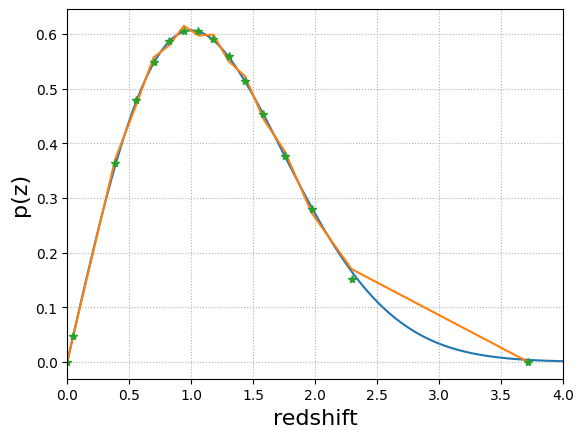

In [4]:
fig, axes = qp.plotting.plot_native(dist1, xlim=(0, 4))
axes.grid(True, linestyle='dotted')
axes.plot(np.squeeze(new_locs), np.squeeze(p_of_zs))


f1 = interp1d(np.squeeze(new_locs[0::2]), np.squeeze(p_of_zs[0::2]), bounds_error=False, fill_value=0.0, kind='cubic')
f2 = interp1d(np.squeeze(new_locs[1::2]), np.squeeze(p_of_zs[1::2]), bounds_error=False, fill_value=0.0, kind='cubic')

y1 = f1(new_locs)
y2 = f2(new_locs)

# axes.plot(np.squeeze(new_locs), y1)
# axes.plot(np.squeeze(new_locs), y2)

axes.plot(np.squeeze(new_locs), (y1 + y2)/2, marker='*', linestyle='None')

np.trapz((y1+y2)/2, new_locs, 0.1)



In [5]:
np.trapz(p_of_zs, new_locs, 0.1)

1.0487049546337524

In [6]:
def interpolate_with_step_function_allowed(quants, locs, dist):
    # creating a new set of locations that is the base locations plus epsilon
    new_locs_with_epsilon = new_locs + sys.float_info.epsilon

    # merge the two sets of locations together and sort
    all_locs = np.concatenate((new_locs, new_locs_with_epsilon))
    all_locs = np.sort(all_locs)

    # calculate the "first term"
    first_term = np.squeeze(2 * np.diff(new_quants) / np.diff(new_locs))
    # print(first_term)
    # print(new_quants.shape)

    # Prepare the p(z_n) array
    p_of_zs = np.zeros(all_locs.shape)

    # we'll start with 0th index for now, and eventually this will change to be whatever the user specifies.
    p_of_zs[0] = dist.pdf(new_locs[0])

    # Calculate p(z_i+1) = first_term_i - p(z_i) 
    # Or, equivalently, p(z_i) = first_term(i-1) - p(z_i-1)
    for i, j in zip(range(1,len(p_of_zs)+2,2), range(1,len(first_term)+1)):
        # print(i,j)
        # print(all_locs[i], new_locs[j-1])

        temp = first_term[j-1] - p_of_zs[i-1]

        if temp < 0.0:
            # if temp < 0, then we replace the trapezoid with a "histogram", or step function.
            height = (new_quants[j] - new_quants[j-1]) / (all_locs[i+1] - all_locs[i])
            p_of_zs[i] = height
            p_of_zs[i+1] = height
        else:
            p_of_zs[i] = p_of_zs[i-1]
            p_of_zs[i+1] = temp


    temp = first_term[-1] - p_of_zs[-3]
    if temp < 0.0:
        p_of_zs[-2] = (new_quants[-1] - new_quants[-2]) / (all_locs[-1] - all_locs[-2])
        p_of_zs[-1] = (new_quants[-1] - new_quants[-2]) / (all_locs[-1] - all_locs[-2])
    else:
        p_of_zs[-2] = temp
        p_of_zs[-1] = 0

    return p_of_zs, all_locs

0.998

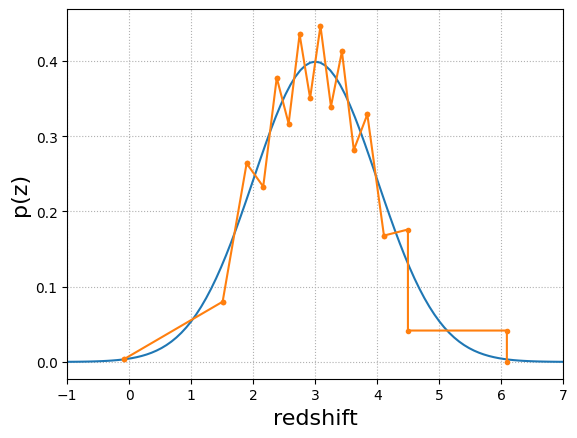

In [7]:
# Working with a normal distribution
dist2 = qp.stats.norm(loc=3, scale=1)

# Starting with a simple base case. Reasonable quantiles >0, <1.0
new_quants = np.linspace(0.001, 0.999, 16)
new_locs = dist2.ppf(new_quants)

p_of_zs, all_locs = interpolate_with_step_function_allowed(new_quants, new_locs, dist2)

fig, axes = qp.plotting.plot_native(dist2, xlim=(-1, 7))
axes.grid(True, linestyle='dotted')
axes.plot(np.squeeze(all_locs), np.squeeze(p_of_zs), marker='.')

# f1 = interp1d(np.squeeze(new_locs[0::2]), np.squeeze(p_of_zs[0::2]), bounds_error=False, fill_value=0.0, kind='cubic')
# f2 = interp1d(np.squeeze(new_locs[1::2]), np.squeeze(p_of_zs[1::2]), bounds_error=False, fill_value=0.0, kind='cubic')

# y1 = f1(new_locs)
# y2 = f2(new_locs)

# axes.plot(np.squeeze(new_locs), y1)
# axes.plot(np.squeeze(new_locs), y2)

# axes.plot(np.squeeze(new_locs), (y1 + y2)/2, marker='*', linestyle='None')

np.trapz(p_of_zs, all_locs, dx=0.1)

In [8]:
#The following methods were extracted from https://github.com/aimalz/qp/blob/master/qp/pdf.py and modified only so that they would run within this notebook. The math has not changed.

epsilon = sys.float_info.epsilon
infty = sys.float_info.max * epsilon

def sandwich(in_arr, ends):
    """
    Adds given values to the ends of a 1D array

    Parameters
    ----------
    in_arr: numpy.ndarray, float
        original array
    ends: numpy.ndarray or tuple or list, float or numpy.ndarray, float
        values to be added to the beginning and end

    Returns
    -------
    out_arr: numpy.ndarray, float
        array with front and back concatenations
    """
    if type(ends[0]) == np.ndarray:
        prepend = len(ends[0])
    else:
        prepend = 1
    if type(ends[-1]) == np.ndarray:
        append = -1 * len(ends[-1])
    else:
        append = -1
    out_arr = np.zeros(prepend + len(in_arr) - append)
    out_arr[:prepend] = ends[0]
    out_arr[prepend:append] = in_arr
    out_arr[append:] = ends[-1]
    return out_arr

def evaluate_histogram(in_data, threshold=epsilon):
    """
    Produces PDF values given samples

    Parameters
    ----------
    in_data: None or tuple, numpy.ndarray, float
        tuple of (n+1) bin endpoints x and (n) CDF y between endpoints
    threshold: float, optional

    vb: boolean, optional
        be careful and print progress to stdout?

    Returns
    -------
    out_data: tuple, float
        sorted samples x and corresponding PDF values y
    """
    # x = locs (or in our case redshift values)
    # y = first derivatives of delta_quant/delta_loc or in our case p(z)
    (x, y) = in_data
    dx = threshold
    xs = np.zeros(2 * len(y))
    ys = xs
    # ! xs defines the bin edges.
    # ! This is creating the bin edges. xs[0] and xs[1] are the edges of the first bin. 
    # ! xs[2] = xs[1]+epsilon becomes the beginning of the second bin, etc.
    # ! Then we "repeat" the y values so that you end up with histogram steps.
    xs[::2] = x[:-1] + dx
    xs[1::2] = x[1:] - dx
    ys = np.repeat(y, 2)
    xs = sandwich(xs, (x[0] - dx, x[-1] + dx))
    ys = sandwich(ys, (threshold, threshold))
    out_data = (xs, ys)
    return out_data

def evaluate_quantiles(in_data, threshold=epsilon):
    """
    Estimates PDF values given quantile information

    Parameters
    ----------
    in_data: tuple, numpy.ndarray, float
        tuple of CDF values iy and values x at which those CDFs are achieved
    threshold: float, optional
        optional minimum threshold for CDF difference
    vb: boolean, optional
        be careful and print progress to stdout?

    Returns
    -------
    out_data: tuple, numpy.ndarray, float
        values xs and corresponding PDF values ys
    """

    # iy = quants
    # x = locs
    (iy, x) = in_data

    # This is the same as np.diff(x)
    dx = x[1:] - x[:-1]
    
    # This is the same as np.diff(iy)
    diy = iy[1:] - iy[:-1]

    # this is the numerical first derivative i.e. p(z)
    y = diy / dx

    # evaluate_histogram(locs, first_derivs)
    (xs, ys) = evaluate_histogram((x, y), threshold=threshold)
    out_data = (xs[1:-1], ys[1:-1])
    return out_data

def normalize_quantiles(in_data, threshold=epsilon):
    """
    Evaluates PDF from quantiles including endpoints from linear extrapolation

    Parameters
    ----------
    in_data: tuple, numpy.ndarray, float
        tuple of CDF values iy corresponding to quantiles and the points x at
        which those CDF values are achieved
    threshold: float, optional
        optional minimum threshold for PDF
    vb: boolean, optional
        be careful and print progress to stdout?

    Returns
    -------
    out_data: tuple, ndarray, float
        tuple of values x at which CDF is achieved, including extrema, and
        normalized PDF values y at x
    """

    # iy = quants
    # x = locs
    (iy, x) = in_data
    (xs, ys) = evaluate_quantiles((iy, x))
    # xs = xs[1:-1]
    # ys = ys[1:-1]

    # ! I believe that this is just using the slope to add end points to the list of x values.
    x_min = xs[0] - 2 * iy[0] / ys[0]
    x_max = xs[-1] + 2 * (1. - iy[-1]) / ys[-1]
    xs = sandwich(xs, (x_min, x_max))
    ys = sandwich(ys, (threshold, threshold))
    out_data = (xs, ys)
    return out_data

def normalize_gridded(in_data, thresholds=(epsilon, infty)):
    """
    Removes extreme values from gridded parametrizations

    Parameters
    ----------
    in_data: None or tuple, numpy.ndarray, float
        tuple of points x at which function is evaluated and the PDF y at those
        points
    thresholds: tuple, float, optional
        optional min/max thresholds for normalization

    Returns
    -------
    out_data: tuple, numpy.ndarray, float
        tuple of input x and normalized y
    """
    if in_data is None:
        return in_data
    (x, y) = in_data
    y[y < thresholds[0]] = thresholds[0]
    y[y > thresholds[-1]] = thresholds[-1]
    out_data = (x, y)
    return out_data

def original_qp_interpolation(quants, locs):

    # ! These are the variable name substitutions I've made
    # quants_and_locs = self.quantiles # A 2d array of quantiles and locations
    # scheme = scheme # using 'linear', used to determine the type of interpolation with interp1d

    scheme = 'linear'
    quants_and_locs = np.array([quants, locs])

    if type(scheme) != int:
        order = min(5, len(quants_and_locs[0]))
    else:
        order = scheme

    # ! Looks like only min(x) and max(x) are used after this in this function, but x,y are used in `quantile_interpolator` later.
    (x, y) = normalize_quantiles(quants_and_locs)
    z = np.insert(quants_and_locs[1], 0, min(x))
    z = np.append(z, max(x))
    q = np.insert(quants_and_locs[0], 0, 0.)
    q = np.append(q, 1.)

    [x_crit_lo, x_crit_hi] = [quants_and_locs[1][0], quants_and_locs[1][-1]]
    [y_crit_lo, y_crit_hi] = [-1., -1.]

    try:
        while (order>0) and ((y_crit_lo <= 0.) or (y_crit_hi <= 0.)):
            inside = InterpolatedUnivariateSpline(z, q, k=order, ext=1).derivative()
            [y_crit_lo, y_crit_hi] = inside([x_crit_lo, x_crit_hi])
            order -= 1
        assert((y_crit_lo > 0.) and (y_crit_hi > 0.))
    except AssertionError:
        print('ERROR: spline tangents '+str((y_crit_lo, y_crit_hi))+'<0')
        if type(scheme) == str:
            this_scheme = scheme
        else:
            this_scheme = 'linear'
        inside_int = interp1d(z, q, kind=this_scheme, bounds_error=False, fill_value=epsilon)
        derivative = (q[1:] - q[:-1]) / (z[1:] - z[:-1])
        derivative = np.insert(derivative, 0, epsilon)
        derivative = np.append(derivative, epsilon)
        def inside(xf):
            nx = len(xf)
            yf = np.ones(nx) * epsilon
            for n in range(nx):
                i = bisect.bisect_left(z, xf[n])
                yf[n] = derivative[i]
            return(yf)
        [y_crit_lo, y_crit_hi] = inside([x_crit_lo, x_crit_hi])
        assert((y_crit_lo > 0.) and (y_crit_hi > 0.))
    return quants_and_locs, x_crit_lo, x_crit_hi, y_crit_lo, y_crit_hi, x, y, z, inside

def quantile_interpolator(quants_and_locs, x_crit_lo, x_crit_hi, y_crit_lo, y_crit_hi, x, y, z, inside, xf):
    yf = np.ones(np.shape(xf)) * epsilon
    in_inds = ((xf >= quants_and_locs[1][0]) & (xf <= quants_and_locs[1][-1])).nonzero()[0]
    lo_inds = ((xf < quants_and_locs[1][0]) & (xf >= z[0])).nonzero()[0]
    hi_inds = ((xf > quants_and_locs[1][-1]) & (xf <= z[-1])).nonzero()[0]

    try:
        yf[in_inds] = inside(xf[in_inds])
        assert(np.all(yf >= epsilon))

    except AssertionError:
        print('ERROR: spline interpolation failed with '+str((xf[in_inds], yf[in_inds])))
        try:
            alternate = interp1d(x, y, kind='linear', bounds_error=False, fill_value=epsilon)
            yf[in_inds] = alternate(xf[in_inds])
            assert(np.all(yf >= epsilon))

        except AssertionError:
            print('ERROR: linear interpolation failed for the '+using+' parametrization with '+str((xf[in_inds], yf[in_inds])))
            backup = qp.utils.make_kludge_interpolator((x, y), threshold=epsilon)
            yf[in_inds] = backup(xf[in_inds])

            assert(np.all(yf >= epsilon))

    try:
        tan_lo = y_crit_lo / (x_crit_lo - z[0])
        yf[lo_inds] = tan_lo * (xf[lo_inds] - z[0])# yf[in_inds[0]] / (xf[in_inds[0]] - z[0])
        assert(np.all(yf >= epsilon))
    except AssertionError:
        print('ERROR: linear extrapolation below failed with '+str((xf[lo_inds], yf[lo_inds]))+' via '+str((tan_lo, x_crit_lo, z[0])))

    try:
        tan_hi = y_crit_hi / (z[-1] - x_crit_hi)
        yf[hi_inds] = tan_hi * (z[-1] - xf[hi_inds])# yf[in_inds[-1]] * (xf[hi_inds] - z[-1]) / (xf[in_inds[-1]] - z[-1])
        assert(np.all(yf >= epsilon))
    except AssertionError:
        print('ERROR: linear extrapolation above failed with '+str((xf[hi_inds], yf[hi_inds]))+' via '+str((tan_hi, z[-1], x_crit_hi)))

    return(yf)

def approximate(quants, locs, grid=None):
        """
        Interpolates the parametrization to get an approximation to the density.

        Parameters
        ----------
        points: ndarray
            the value(s) at which to evaluate the interpolated function
        

        Returns
        -------
        points: ndarray, float
            the input grid upon which to interpolate
        interpolated: ndarray, float
            the interpolated points.

        Notes
        -----
        Extrapolation is via the `scheme` while values are positive;
        otherwise, extrapolation returns 0.

        Example:
            x, y = p.approximate(np.linspace(-1., 1., 100))
        """
        if grid is None:
            grid = locs

        quants_and_locs, x_crit_lo, x_crit_hi, y_crit_lo, y_crit_hi, x, y, z, inside = original_qp_interpolation(quants, locs)

        interpolated = quantile_interpolator(quants_and_locs, x_crit_lo, x_crit_hi, y_crit_lo, y_crit_hi, x, y, z, inside, grid)
        
        # ! Drew commented this out just to see what would happen, and it doesn't seem to have an immediate affect
        interpolated = normalize_gridded((grid, interpolated))

        return interpolated

0.998000000000001

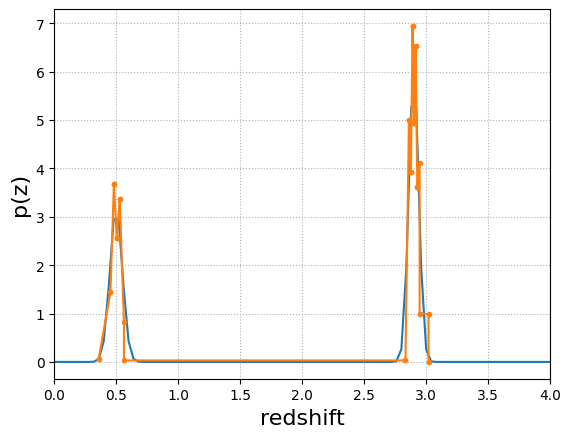

In [9]:
# Experimenting with well separated multi-modal Gaussians.
mu = np.array([0.5,1.1,2.9])
sig = np.array([0.05,0.01,0.04])
wt = np.array([.2,.5,.3])

mu = np.array([0.5,2.9])
sig = np.array([0.05,0.04])
wt = np.array([.4,.6])

dist3 = qp.Ensemble(qp.mixmod, data=dict(means=mu, stds=sig, weights=wt))

# Starting with a simple base case. Reasonable quantiles >0, <1.0
new_quants = np.linspace(0.001, 0.999, 15)
new_locs = dist3.ppf(new_quants)

p_of_zs, all_locs = interpolate_with_step_function_allowed(new_quants, new_locs, dist3)

fig, axes = qp.plotting.plot_native(dist3, xlim=(0, 4))
axes.grid(True, linestyle='dotted')
axes.plot(np.squeeze(all_locs), np.squeeze(p_of_zs), marker='.')

np.trapz(p_of_zs, all_locs, dx=0.1)

ERROR: spline interpolation failed with (array([0.4040404 , 0.45454545, 0.50505051, 0.55555556, 0.60606061,
       0.65656566, 0.70707071, 0.75757576, 0.80808081, 0.85858586,
       0.90909091, 0.95959596, 1.01010101, 1.06060606, 1.11111111,
       1.16161616, 1.21212121, 1.26262626, 1.31313131, 1.36363636,
       1.41414141, 1.46464646, 1.51515152, 1.56565657, 1.61616162,
       1.66666667, 1.71717172, 1.76767677, 1.81818182, 1.86868687,
       1.91919192, 1.96969697, 2.02020202, 2.07070707, 2.12121212,
       2.17171717, 2.22222222, 2.27272727, 2.32323232, 2.37373737,
       2.42424242, 2.47474747, 2.52525253, 2.57575758, 2.62626263,
       2.67676768, 2.72727273, 2.77777778, 2.82828283, 2.87878788,
       2.92929293, 2.97979798]), array([  0.45237585,   2.09493306,   3.15589098,   1.75145882,
         0.32953306,  -0.56511098,  -1.005467  ,  -1.06081189,
        -0.79653633,  -0.27414479,   0.4487445 ,   1.31839951,
         2.28497444,   3.30250969,   4.32893191,   5.32605393,
    

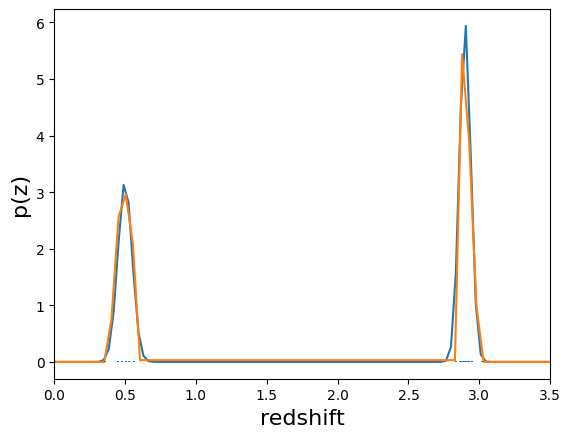

In [10]:
# ! When this runs it uses linear interpolation of x,y in the first `except` clause in quantile_interpolator
# ! Those x,y values are coming out of (x, y) = normalize_quantiles(quants_and_locs) in original_qp_interpolation
test = approximate(new_quants, new_locs, np.linspace(0,5,100))
fig, axes = qp.plotting.plot_native(dist3, xlim=(0, 3.5))
axes.plot(test[0], test[1])
axes.vlines(new_locs, 0, 0.01)

This is the new "merged" multi modal Gaussian example

0.9980000000000002

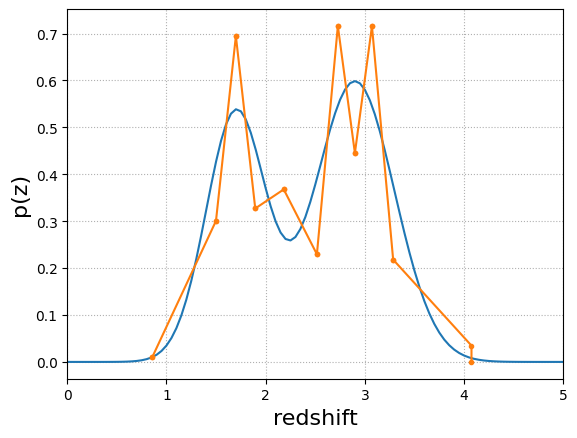

In [11]:
# Experimenting with well separated multi-modal Gaussians.
mu = np.array([1.7, 2.9])
sig = np.array([0.3,0.4])
wt = np.array([0.4, 0.6])

dist4 = qp.Ensemble(qp.mixmod, data=dict(means=mu, stds=sig, weights=wt))

new_quants = np.linspace(0.001, 0.999, 11)
new_locs = dist4.ppf(new_quants)

p_of_zs, all_locs = interpolate_with_step_function_allowed(new_quants, new_locs, dist4)

fig, axes = qp.plotting.plot_native(dist4, xlim=(0, 5))
axes.grid(True, linestyle='dotted')
axes.plot(np.squeeze(all_locs), np.squeeze(p_of_zs), marker='.')

np.trapz(p_of_zs, all_locs, dx=0.1)

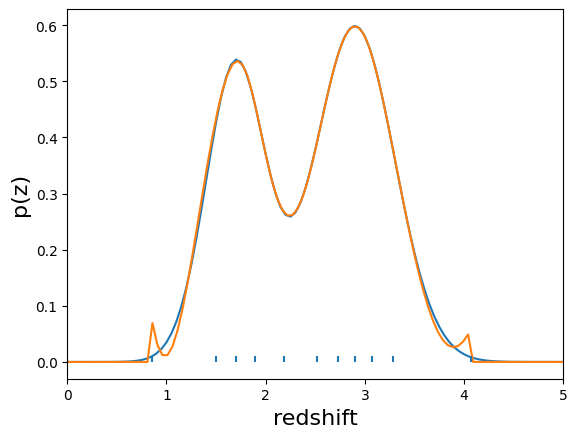

In [12]:
# ! When this runs it uses 4th degree spline interpolator as `inside` in quantile_interpolator
test = approximate(new_quants, new_locs, np.linspace(0,5,100))
fig, axes = qp.plotting.plot_native(dist4, xlim=(0, 5))
axes.plot(test[0], test[1])
axes.vlines(new_locs, 0, 0.01)

In [13]:
# just running a test that the CDF is still right on this 
# (or, rather, we don't expect perfection from a spline, but we at least want it to be close)
# aside: this check is common enough that we probably want a shortcut to it somewhere
dx = 0.01
xran = np.arange(0,5,dx)
test = approximate(new_quants, new_locs, xran)

for i, q in enumerate(new_quants):
    ind = bisect.bisect(xran, new_locs[i])
    # print(np.trapz(test[:ind], xran[:ind]) - q)

The following code was taken from this notebook: https://github.com/LSSTDESC/transient-host-sims/blob/zquant/notebooks/using_quantiles_demo.ipynb
Specifically the section "Reconstructing PDFs from quantiles". However, it looks very much like we're just taking the numerical derivative, which is basically the piece-wise constant approach that we were trying to correct from the beginning.

1.0105569147664495

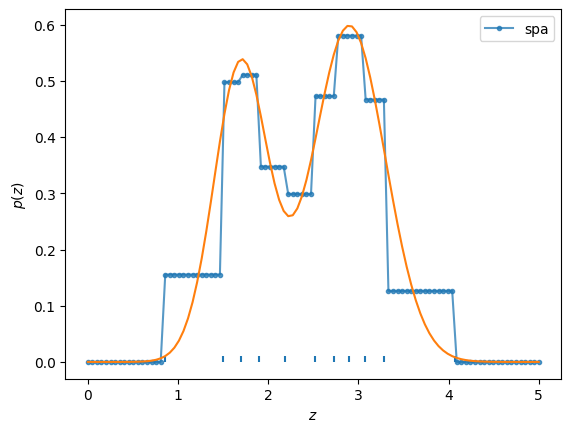

In [14]:
q = new_quants
z = new_locs
eps = sys.float_info.epsilon

derivative = (q[1:] - q[:-1]) / (z[1:] - z[:-1])
derivative = np.insert(derivative, 0, eps)
derivative = np.append(derivative, eps)
def inside(xf):
    nx = len(xf)
    yf = np.ones(nx) * eps
    for n in range(nx):
        i = bisect.bisect_left(z, xf[n])
        yf[n] = derivative[i]
    return(yf)

zgrid = {}
zgrid['spa'] = np.linspace(0., 5., 100)#zq_vals

# zgrid['log'] = np.logspace(-3., np.log10(5.), 300)
# zgrid['lin'] = np.arange(0., 5.01, 0.01)
# zgrid['den'] = np.linspace(0., 5., 1000)

eval_pdf = {}
for key, val in zgrid.items():
    eval_pdf[key] = inside(val)


for key in zgrid.keys():
    plt.plot(zgrid[key], eval_pdf[key], '-o', markersize=3, label=key, alpha=0.75)

plt.vlines(new_locs, 0, 0.01)
plt.plot(zgrid['spa'], dist4.pdf(zgrid['spa']))
plt.xlabel('$z$')
plt.ylabel('$p(z)$')
plt.legend(loc='upper right')

np.trapz(eval_pdf[key], zgrid[key])

0.9979999999999998
ERROR: spline interpolation failed with (array([0.36363636, 0.39393939, 0.42424242, 0.45454545, 0.48484848,
       0.51515152, 0.54545455, 0.57575758, 0.60606061, 0.63636364,
       0.66666667, 0.6969697 , 0.72727273, 0.75757576, 0.78787879,
       0.81818182, 0.84848485, 0.87878788, 0.90909091, 0.93939394,
       0.96969697, 1.        , 1.03030303, 1.06060606, 1.09090909,
       1.12121212, 1.15151515, 1.18181818, 1.21212121, 1.24242424,
       1.27272727, 1.3030303 , 1.33333333, 1.36363636, 1.39393939,
       1.42424242, 1.45454545, 1.48484848, 1.51515152, 1.54545455,
       1.57575758, 1.60606061, 1.63636364, 1.66666667, 1.6969697 ,
       1.72727273, 1.75757576, 1.78787879, 1.81818182, 1.84848485,
       1.87878788, 1.90909091, 1.93939394, 1.96969697, 2.        ,
       2.03030303, 2.06060606, 2.09090909, 2.12121212, 2.15151515,
       2.18181818, 2.21212121, 2.24242424, 2.27272727, 2.3030303 ,
       2.33333333, 2.36363636, 2.39393939, 2.42424242, 2.45454545,
  

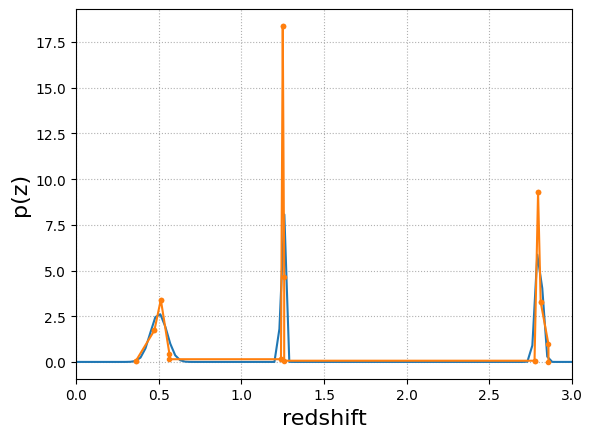

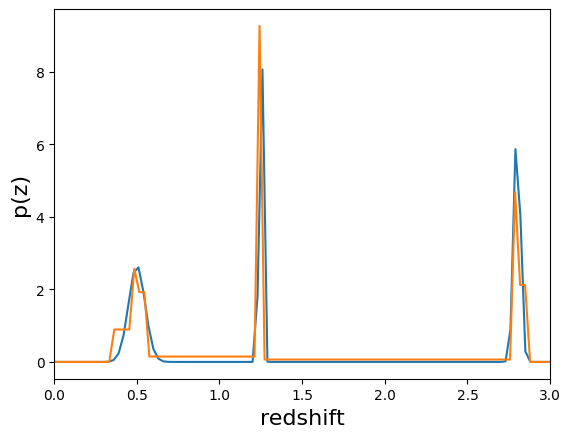

In [15]:
mu = np.array([0.5, 1.25, 2.8])
sig = np.array([0.05,0.01,0.02])

wt = np.array([1/3,1/3,1/3])

dist5 = qp.Ensemble(qp.mixmod, data=dict(means=mu, stds=sig, weights=wt))

new_quants = np.linspace(0.001, 0.999, 11)
new_locs = dist5.ppf(new_quants)

p_of_zs, all_locs = interpolate_with_step_function_allowed(new_quants, new_locs, dist5)

fig, axes = qp.plotting.plot_native(dist5, xlim=(0, 3))
axes.grid(True, linestyle='dotted')
axes.plot(np.squeeze(all_locs), np.squeeze(p_of_zs), marker='.')

print(np.trapz(p_of_zs, all_locs, dx=0.1))

test = approximate(new_quants, new_locs, np.linspace(0,3,100))
fig, axes = qp.plotting.plot_native(dist5, xlim=(0, 3))
axes.plot(test[0], test[1])
axes.vlines(new_locs, 0, 0.01)

print(np.trapz(test, np.linspace(0,3,100), dx=0.1))